### Patagonia trip - extract meteo

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
# define here some variables:
ROOT_GPX_FILES = '/Users/filippomichelon/Documents/PersonalCode/garmin_patagonia_gpx_files'


/Users/filippomichelon/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# define here the function to extract .gpx files from a folder and extract it
import gpxpy
import gpxpy.gpx
import pandas as pd
import os
from typing import List

def extract_gpx_files_from_folder(folder_path: str) -> pd.DataFrame:
    """
    Extracts multiple .gpx files from a specified folder and combines their data into a Pandas DataFrame.
    
    Parameters:
    folder_path (str): Path to the folder containing .gpx files.
    
    Returns:
    pd.DataFrame: DataFrame containing latitude, longitude, elevation, time, and file name.
    """
    data = []
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.gpx')]
    
    for file_path in file_paths:
        with open(file_path, 'r') as gpx_file:
            gpx = gpxpy.parse(gpx_file)
            for track in gpx.tracks:
                for segment in track.segments:
                    for point in segment.points:
                        data.append({
                            'latitude': point.latitude,
                            'longitude': point.longitude,
                            'elevation': point.elevation,
                            'time': point.time,
                            'file': os.path.basename(file_path)
                        })
    
    return pd.DataFrame(data)

df = extract_gpx_files_from_folder(ROOT_GPX_FILES)
df

,latitude,longitude,elevation,time,file
0,-47.513040,-72.864786,95.000000,2025-02-13 12:15:59+00:00,activity_18305731843.gpx
1,-47.513040,-72.864781,95.000000,2025-02-13 12:16:00+00:00,activity_18305731843.gpx
2,-47.512932,-72.864581,95.599998,2025-02-13 12:17:13+00:00,activity_18305731843.gpx
3,-47.512929,-72.864558,95.800003,2025-02-13 12:17:14+00:00,activity_18305731843.gpx
4,-47.512924,-72.864536,95.800003,2025-02-13 12:17:15+00:00,activity_18305731843.gpx
...,...,...,...,...,...
184289,-45.173780,-72.147552,101.199997,2025-02-23 17:38:13+00:00,activity_18367810592.gpx
184290,-45.173763,-72.147549,101.199997,2025-02-23 17:38:14+00:00,activity_18367810592.gpx
184291,-45.173755,-72.147546,101.199997,2025-02-23 17:38:15+00:00,activity_18367810592.gpx
184292,-45.173748,-72.147545,101.199997,2025-02-23 17:38:16+00:00,activity_18367810592.gpx


In [ ]:

for day in df['file'].unique():
    day_track = df[df['file'] == day]

In [4]:
import pandas as pd
import requests

def generate_meteo_url(latitude: float, longitude: float, date: str, hour: str) -> str:
    """
    Generates the Open-Meteo API URL with the specified parameters for latitude, longitude, date, and hour.
    """
    base_url = "https://api.open-meteo.com/v1/forecast"
    url = f"{base_url}?latitude={latitude}&longitude={longitude}&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,winddirection_10m&start_date={date}&end_date={date}&hourly={hour}&format=csv"
    return url

def get_weather_for_time(df: pd.DataFrame) -> pd.DataFrame:
    """
    Gets the weather data for each time in df.time and returns a DataFrame with the weather info.
    
    Parameters:
    df (pd.DataFrame): DataFrame with 'latitude', 'longitude', and 'time' columns containing coordinates and timestamps.
    
    Returns:
    pd.DataFrame: A DataFrame containing weather data corresponding to each time in df.
    """
    weather_data = []
    
    for _, row in df.iterrows():
        latitude = row['latitude']
        longitude = row['longitude']
        timestamp = row['time']
        
        # Extract date and hour from the timestamp
        date = timestamp.strftime('%Y-%m-%d')
        hour = timestamp.strftime('%H')
        
        # Generate the URL for the Open-Meteo API based on the date and hour
        url = generate_meteo_url(latitude, longitude, date, hour)
        
        # Request the data from the API
        response = requests.get(url)
        
        if response.status_code == 200:
            # Parse the CSV response into a DataFrame
            meteo_df = pd.read_csv(pd.compat.StringIO(response.text), skiprows=6)  # Skip the header rows
            # Extract the weather data for that time
            weather_info = meteo_df[meteo_df['time'] == timestamp.strftime('%Y-%m-%dT%H:%M:%SZ')].iloc[0]
            weather_info['latitude'] = latitude
            weather_info['longitude'] = longitude
            weather_info['time'] = timestamp
            weather_data.append(weather_info)
        else:
            print(f"Error fetching data for {timestamp}: {response.status_code}")
    
    # Return the weather data as a DataFrame
    return pd.DataFrame(weather_data)

# Example usage:
# Assuming df is your DataFrame with 'latitude', 'longitude', and 'time' columns
#weather_df = get_weather_for_time(df)
#print(weather_df)


In [6]:
weather_df = get_weather_for_time(df.tail(3))
print(weather_df)

Error fetching data for 2025-02-23 17:38:15+00:00: 400
Error fetching data for 2025-02-23 17:38:16+00:00: 400
Error fetching data for 2025-02-23 17:38:17+00:00: 400
Empty DataFrame
Columns: []
Index: []


In [40]:
import numpy as np
#LUIGI'S FUNCTION 
# Take the meteo dataset using the function below
def get_meteo_dataset():
    """Get the meteo dataset from the open-meteo API.
    Note how easy it is to get data from the web with pandas! As long as we give the URL of the csv data, pandas can read it.
    """
    np.random.seed(42)
    URL = "https://api.open-meteo.com/v1/forecast?latitude=-45&longitude=-72&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,precipitation,wind_speed_10m,winddirection_10m&start_date=2025-02-07&end_date=2025-03-08&format=csv"
    df = pd.read_csv(URL, skiprows=6)  # read the csv file, skipping the first 3 rows (a header)
    df.columns = [col.split(" ")[0] for col in df.columns]  # simplify column names
    df["time"] = pd.to_datetime(df["time"])  # convert the time column to datetime
    df["hour"], df["dayofyear"] = df["time"].dt.hour, df["time"].dt.dayofyear  # extract the hour and day of year
    df["weekdays"] = df["time"].dt.day_name()  # extract the day of the week

    return df

meteo_df = get_meteo_dataset()
meteo_df

,time,temperature_2m,precipitation,wind_speed_10m,winddirection_10m,hour,dayofyear,weekdays
0,2025-02-07 00:00:00,7.1,0.0,11.9,295,0,38,Friday
1,2025-02-07 01:00:00,6.4,0.0,8.9,310,1,38,Friday
2,2025-02-07 02:00:00,6.2,0.0,8.4,313,2,38,Friday
3,2025-02-07 03:00:00,5.9,0.0,7.2,323,3,38,Friday
4,2025-02-07 04:00:00,5.7,0.0,7.1,336,4,38,Friday
...,...,...,...,...,...,...,...,...
715,2025-03-08 19:00:00,9.2,0.0,13.8,290,19,67,Saturday
716,2025-03-08 20:00:00,9.4,0.0,13.4,294,20,67,Saturday
717,2025-03-08 21:00:00,8.9,0.0,12.7,295,21,67,Saturday
718,2025-03-08 22:00:00,8.2,0.0,11.3,301,22,67,Saturday


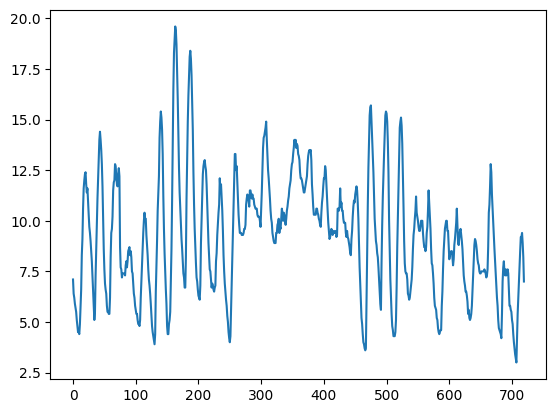

In [47]:
plt.figure()
plt.plot(meteo_df.temperature_2m)


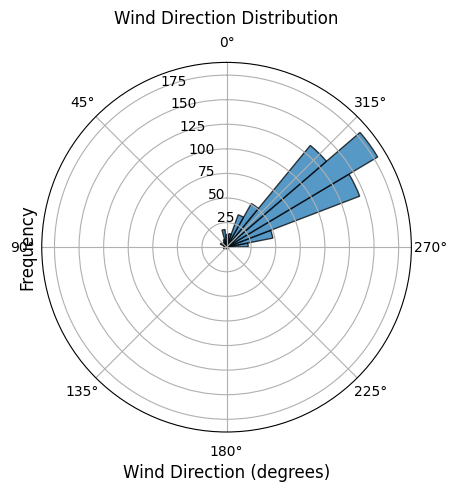

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Convert wind directions to radians (polar plot requires radians)
angles = np.radians(meteo_df['winddirection_10m'])

# Create a figure and axis for the polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the wind directions as a histogram (default bins are in degrees)
ax.hist(angles, bins=36, edgecolor='black', alpha=0.75)

# Set the rotation to put North at the top (90 degrees counterclockwise)
ax.set_theta_zero_location('N')

# Add labels and title
ax.set_title('Wind Direction Distribution', va='bottom')
ax.set_xlabel('Wind Direction (degrees)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Display the plot
plt.show()



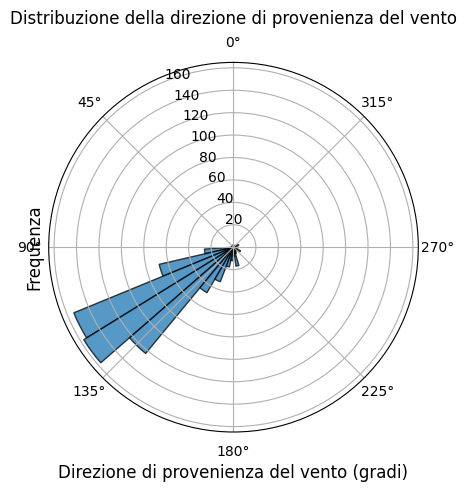

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Converti la direzione del vento in radianti e correggi per mostrare la provenienza
angles = np.radians((meteo_df['winddirection_10m'] + 180) % 360)  # Aggiungi 180° per la provenienza del vento

# Crea il grafico polare
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Istogramma delle direzioni del vento con 36 bin (un per ogni 10°)
ax.hist(angles, bins=36, edgecolor='black', alpha=0.75)

# Posiziona il Nord in alto
ax.set_theta_zero_location('N')

# Aggiungi etichette e titolo
ax.set_title('Distribuzione della direzione di provenienza del vento', va='bottom')
ax.set_xlabel('Direzione di provenienza del vento (gradi)', fontsize=12)
ax.set_ylabel('Frequenza', fontsize=12)

# Mostra il grafico
plt.show()


Text(0, 0.5, 'Frequency')

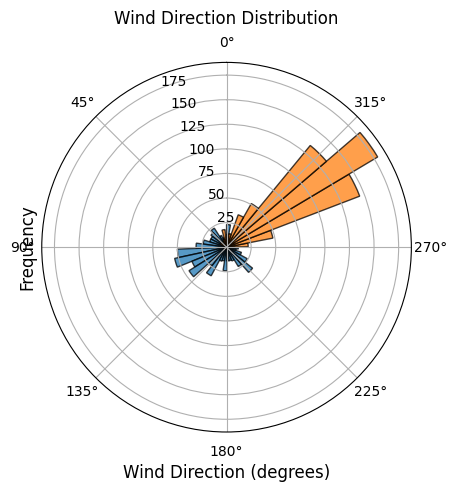

In [46]:
import numpy as np
#LUIGI'S FUNCTION 
# Take the meteo dataset using the function below
def get_meteo_dataset():
    """Get the meteo dataset from the open-meteo API.
    Note how easy it is to get data from the web with pandas! As long as we give the URL of the csv data, pandas can read it.
    """
    np.random.seed(42)
    URL = "https://api.open-meteo.com/v1/forecast?latitude=46&longitude=11&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,precipitation,wind_speed_10m,winddirection_10m&start_date=2025-02-07&end_date=2025-03-08&format=csv"
    df = pd.read_csv(URL, skiprows=6)  # read the csv file, skipping the first 3 rows (a header)
    df.columns = [col.split(" ")[0] for col in df.columns]  # simplify column names
    df["time"] = pd.to_datetime(df["time"])  # convert the time column to datetime
    df["hour"], df["dayofyear"] = df["time"].dt.hour, df["time"].dt.dayofyear  # extract the hour and day of year
    df["weekdays"] = df["time"].dt.day_name()  # extract the day of the week

    return df

meteo_df = get_meteo_dataset()
meteo_df

import matplotlib.pyplot as plt
import numpy as np

# Convert wind directions to radians (polar plot requires radians)
angles = np.radians(meteo_df['winddirection_10m'])

# Create a figure and axis for the polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the wind directions as a histogram (default bins are in degrees)
ax.hist(angles, bins=36, edgecolor='black', alpha=0.75)

# Set the rotation to put North at the top (90 degrees counterclockwise)
ax.set_theta_zero_location('N')

# Add labels and title
ax.set_title('Wind Direction Distribution', va='bottom')
ax.set_xlabel('Wind Direction (degrees)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

def get_meteo_dataset():
    """Get the meteo dataset from the open-meteo API.
    Note how easy it is to get data from the web with pandas! As long as we give the URL of the csv data, pandas can read it.
    """
    np.random.seed(42)
    URL = "https://api.open-meteo.com/v1/forecast?latitude=-45&longitude=-72&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,precipitation,wind_speed_10m,winddirection_10m&start_date=2025-02-07&end_date=2025-03-08&format=csv"
    df = pd.read_csv(URL, skiprows=6)  # read the csv file, skipping the first 3 rows (a header)
    df.columns = [col.split(" ")[0] for col in df.columns]  # simplify column names
    df["time"] = pd.to_datetime(df["time"])  # convert the time column to datetime
    df["hour"], df["dayofyear"] = df["time"].dt.hour, df["time"].dt.dayofyear  # extract the hour and day of year
    df["weekdays"] = df["time"].dt.day_name()  # extract the day of the week

    return df

meteo_df = get_meteo_dataset()
meteo_df

# Convert wind directions to radians (polar plot requires radians)
angles = np.radians(meteo_df['winddirection_10m'])

# Plot the wind directions as a histogram (default bins are in degrees)
ax.hist(angles, bins=36, edgecolor='black', alpha=0.75)

# Set the rotation to put North at the top (90 degrees counterclockwise)
ax.set_theta_zero_location('N')

# Add labels and title
ax.set_title('Wind Direction Distribution', va='bottom')
ax.set_xlabel('Wind Direction (degrees)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

